# Optimization 


Training Q Learning


Q Learning Training: 100%|██████████████████████████████████████████████████████| 50000/50000 [02:08<00:00, 390.52it/s]



=== Q Learning Results ===
1. Final Success Rate: 87.20%
2. Average Reward: 0.872 ± 0.334
3. Best Rolling Average Return: 0.607
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0023 seconds
6. Policy converged after ~1001 episodes
Training Time: 128.04 seconds


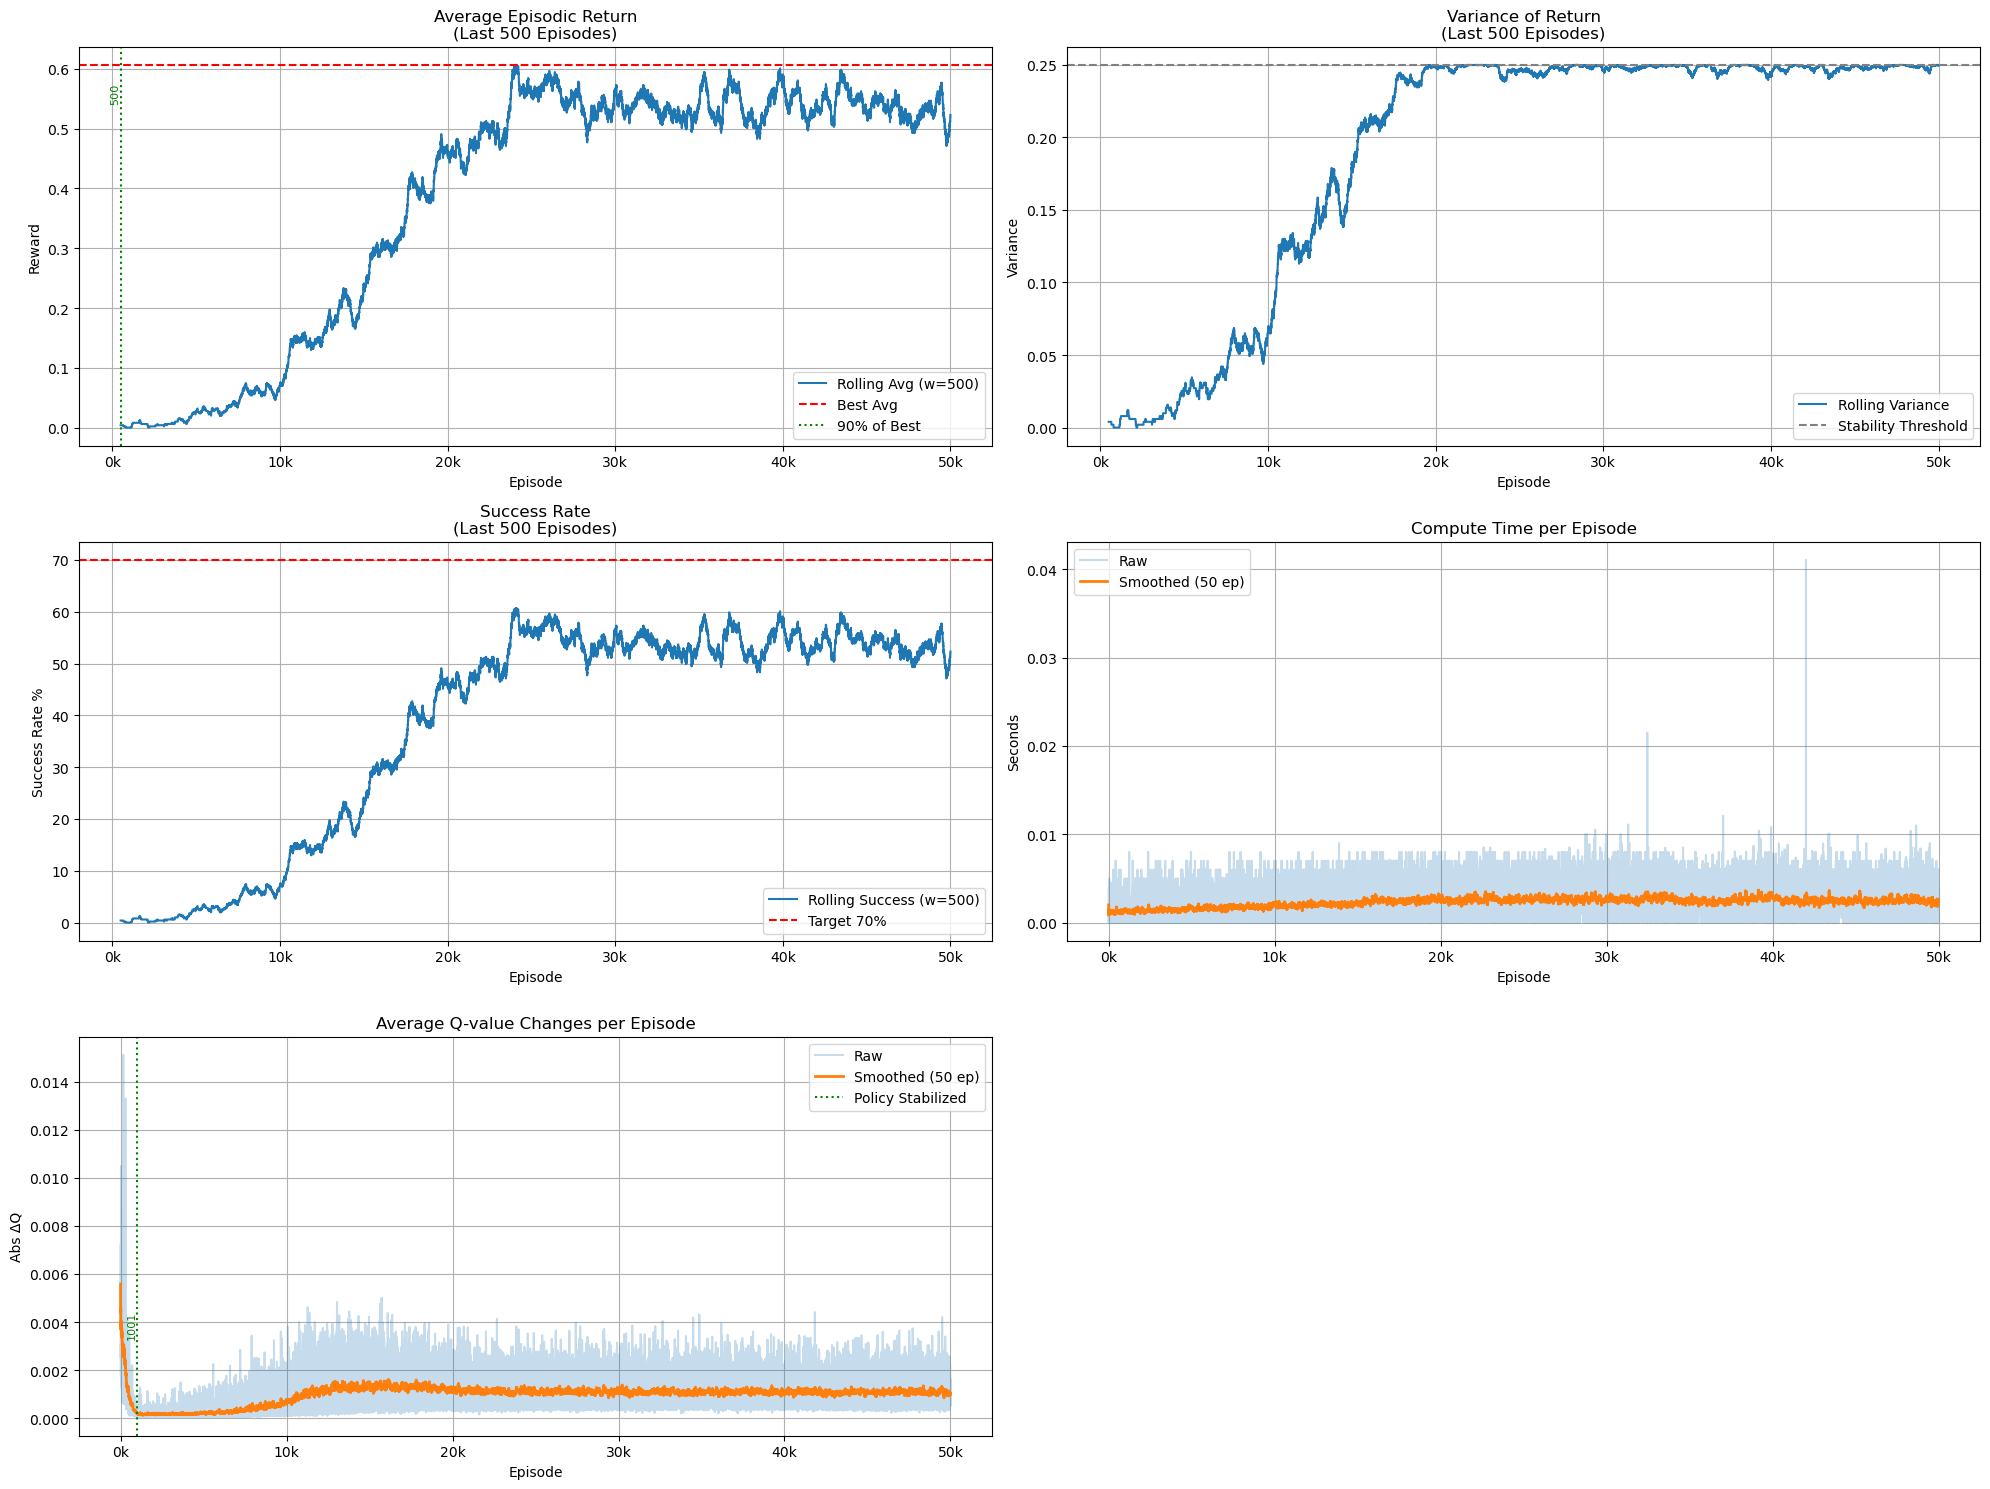


Training Sarsa Lambda


Sarsa Lambda Training: 100%|██████████████████████████████████████████████████| 100000/100000 [04:22<00:00, 380.87it/s]



=== Sarsa Lambda Results ===
1. Final Success Rate: 77.63%
2. Average Reward: 0.776 ± 0.417
3. Best Rolling Average Return: 0.716
4. Episodes to reach 90% of best: 1000
5. Average Compute Time per Episode: 0.0023 seconds
6. Policy did not fully converge during training
Training Time: 262.57 seconds


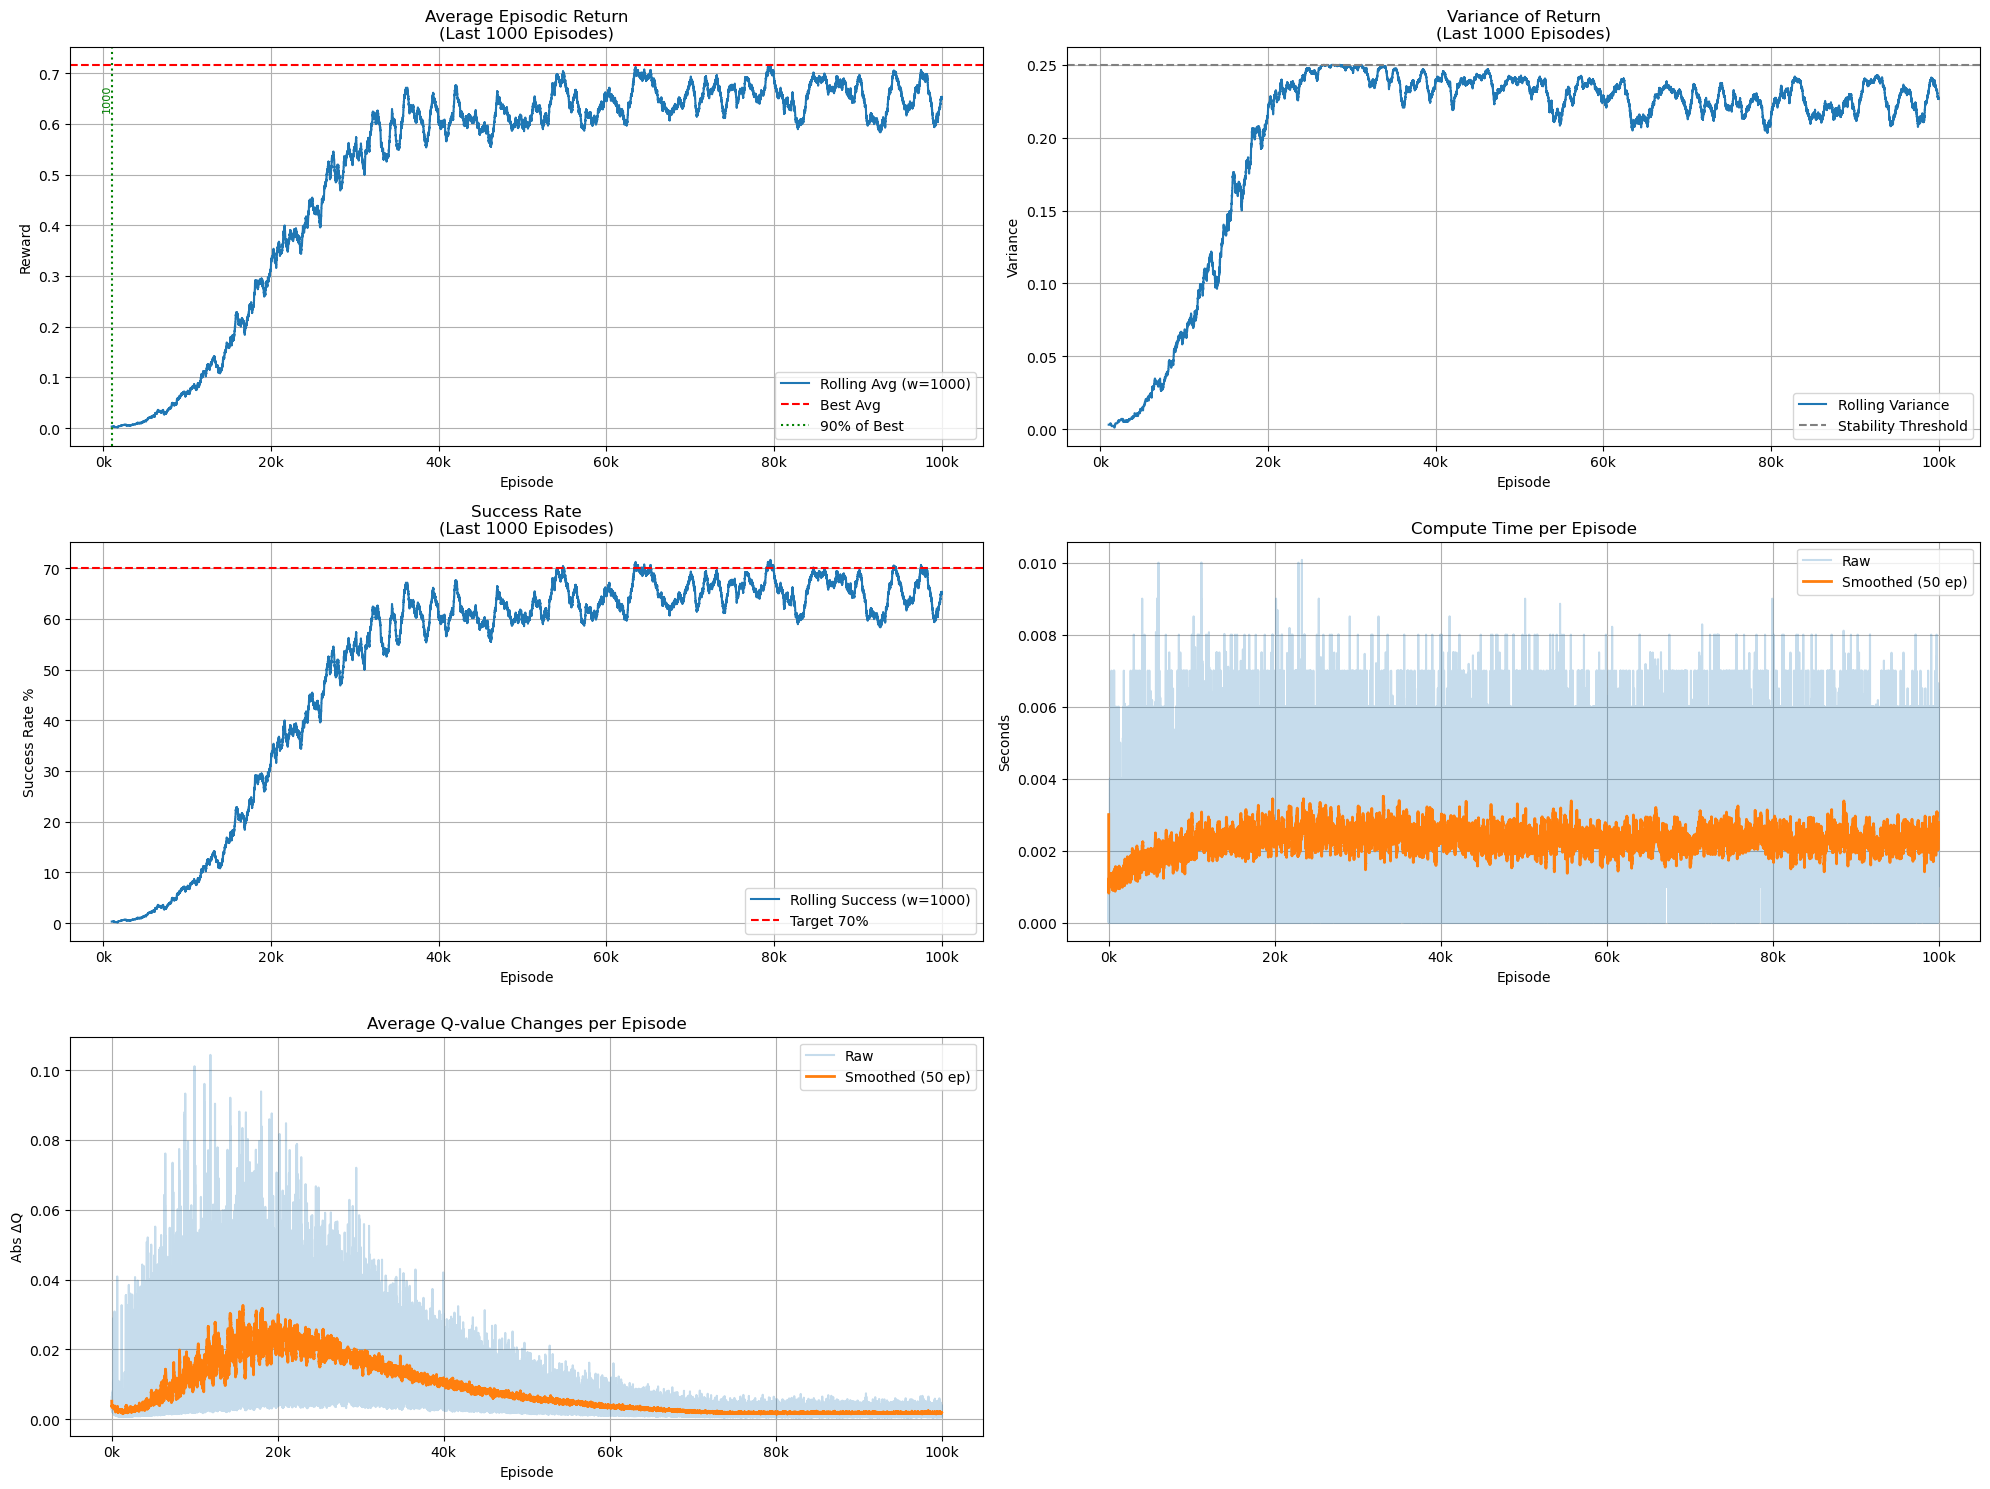


Training Q Lambda


Q Lambda Training: 100%|██████████████████████████████████████████████████████| 100000/100000 [04:51<00:00, 343.08it/s]



=== Q Lambda Results ===
1. Final Success Rate: 73.70%
2. Average Reward: 0.737 ± 0.440
3. Best Rolling Average Return: 0.573
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0027 seconds
6. Policy converged after ~55154 episodes
Training Time: 291.48 seconds


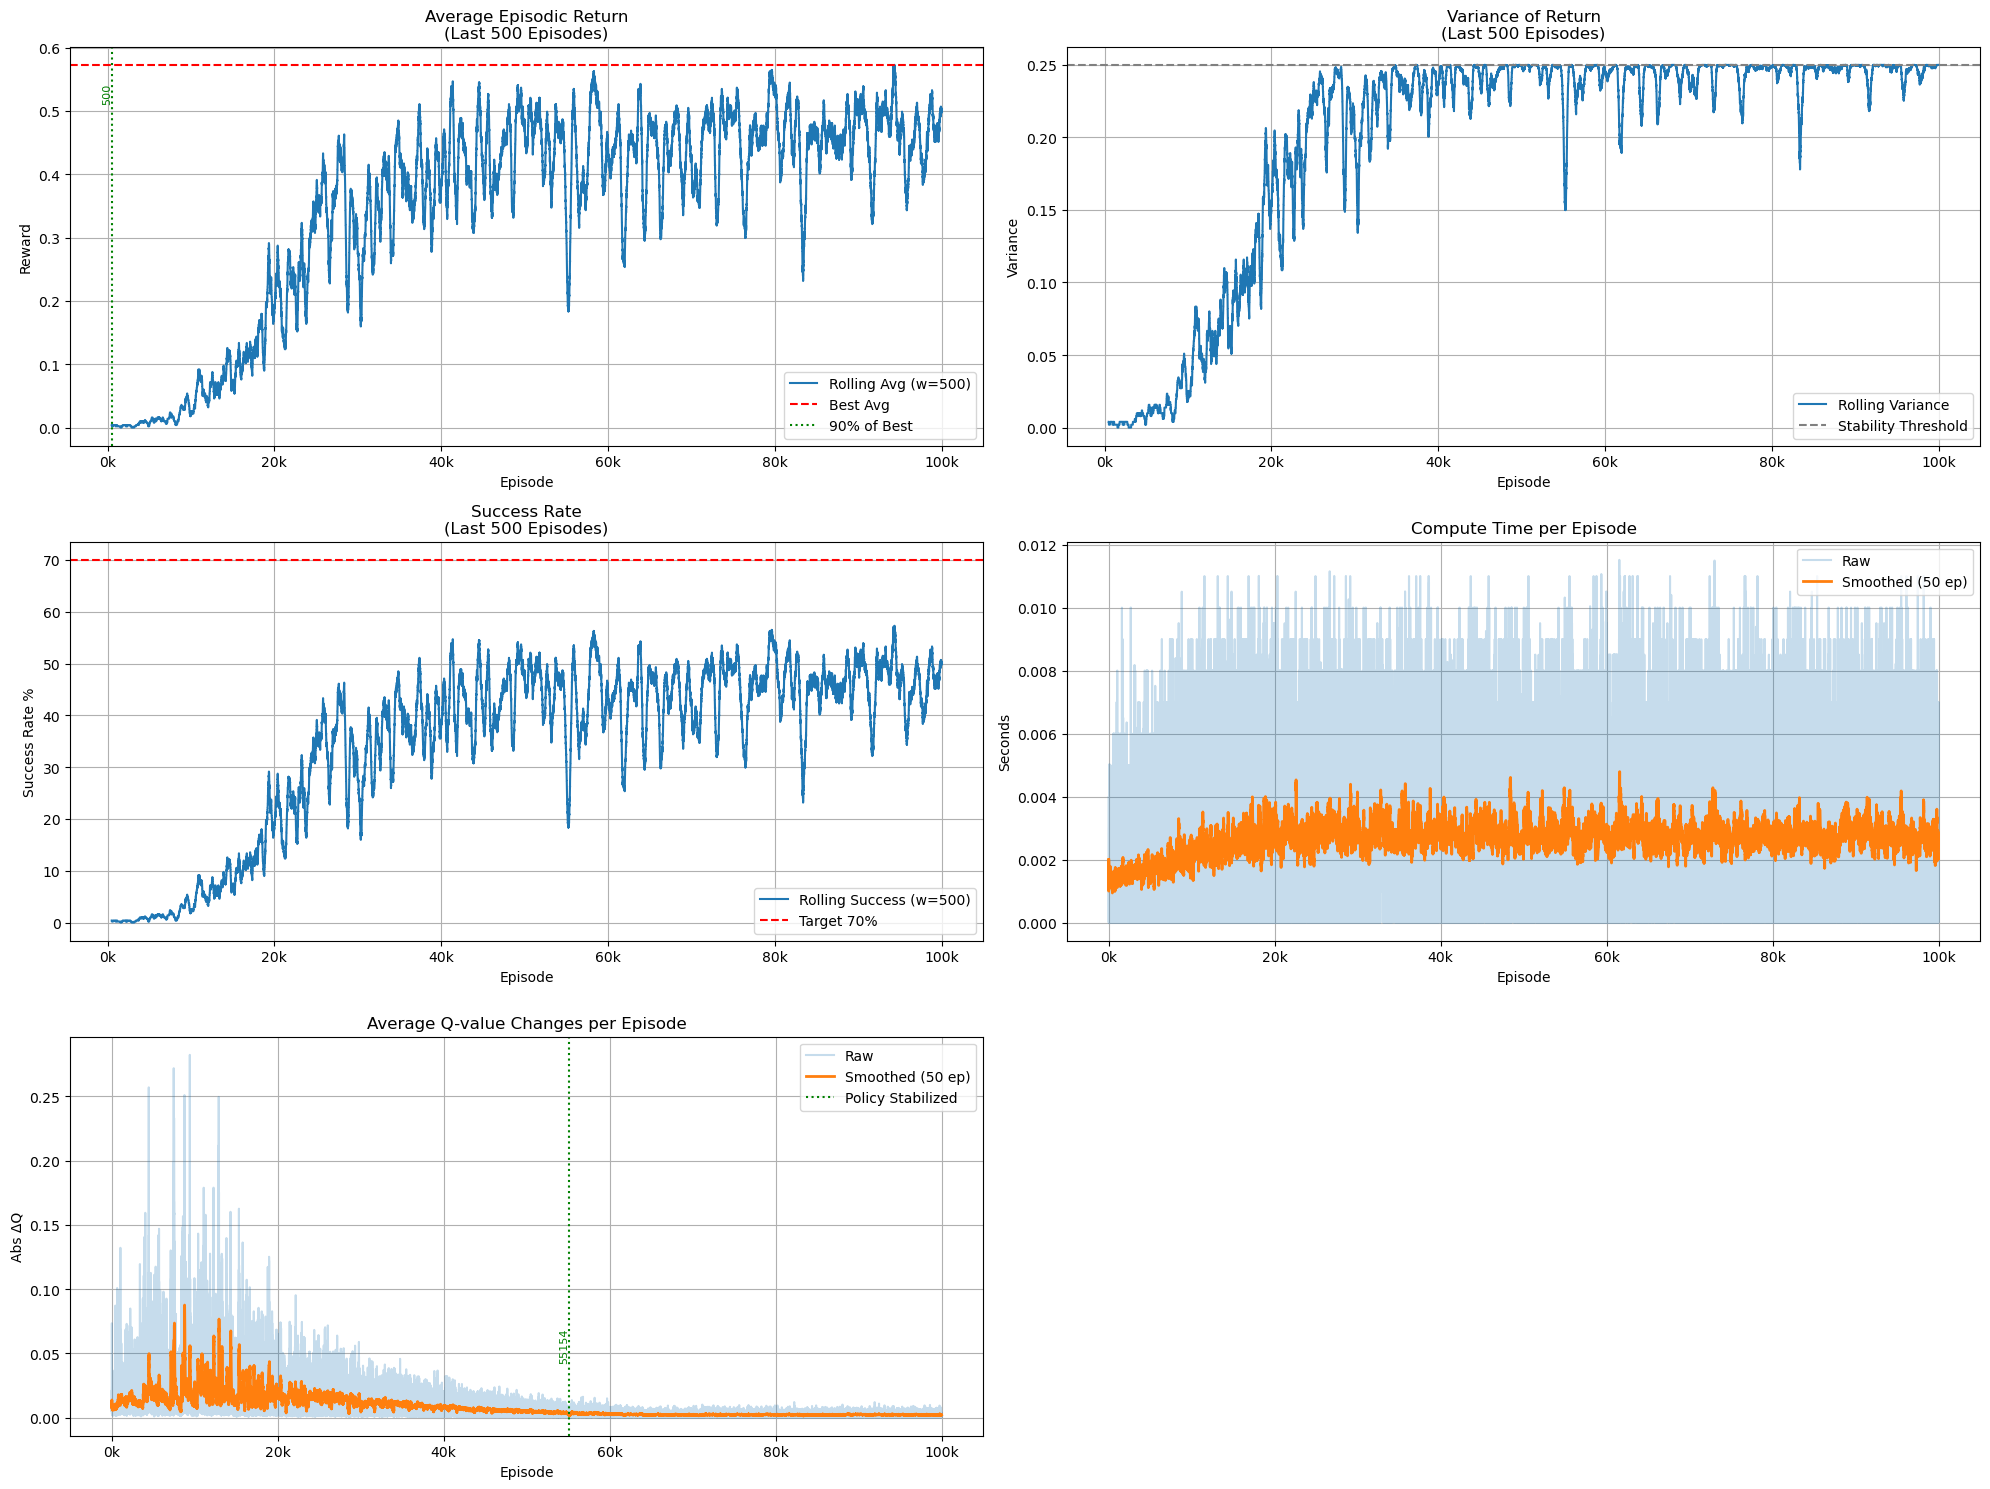


Training Monte Carlo


Monte Carlo Training: 100%|███████████████████████████████████████████████████| 100000/100000 [02:09<00:00, 772.35it/s]



=== Monte Carlo Results ===
1. Final Success Rate: 71.33%
2. Average Reward: 0.713 ± 0.452
3. Best Rolling Average Return: 0.109
4. Episodes to reach 90% of best: 1000
5. Average Compute Time per Episode: 0.0010 seconds
6. Policy converged after ~2001 episodes
Training Time: 129.48 seconds


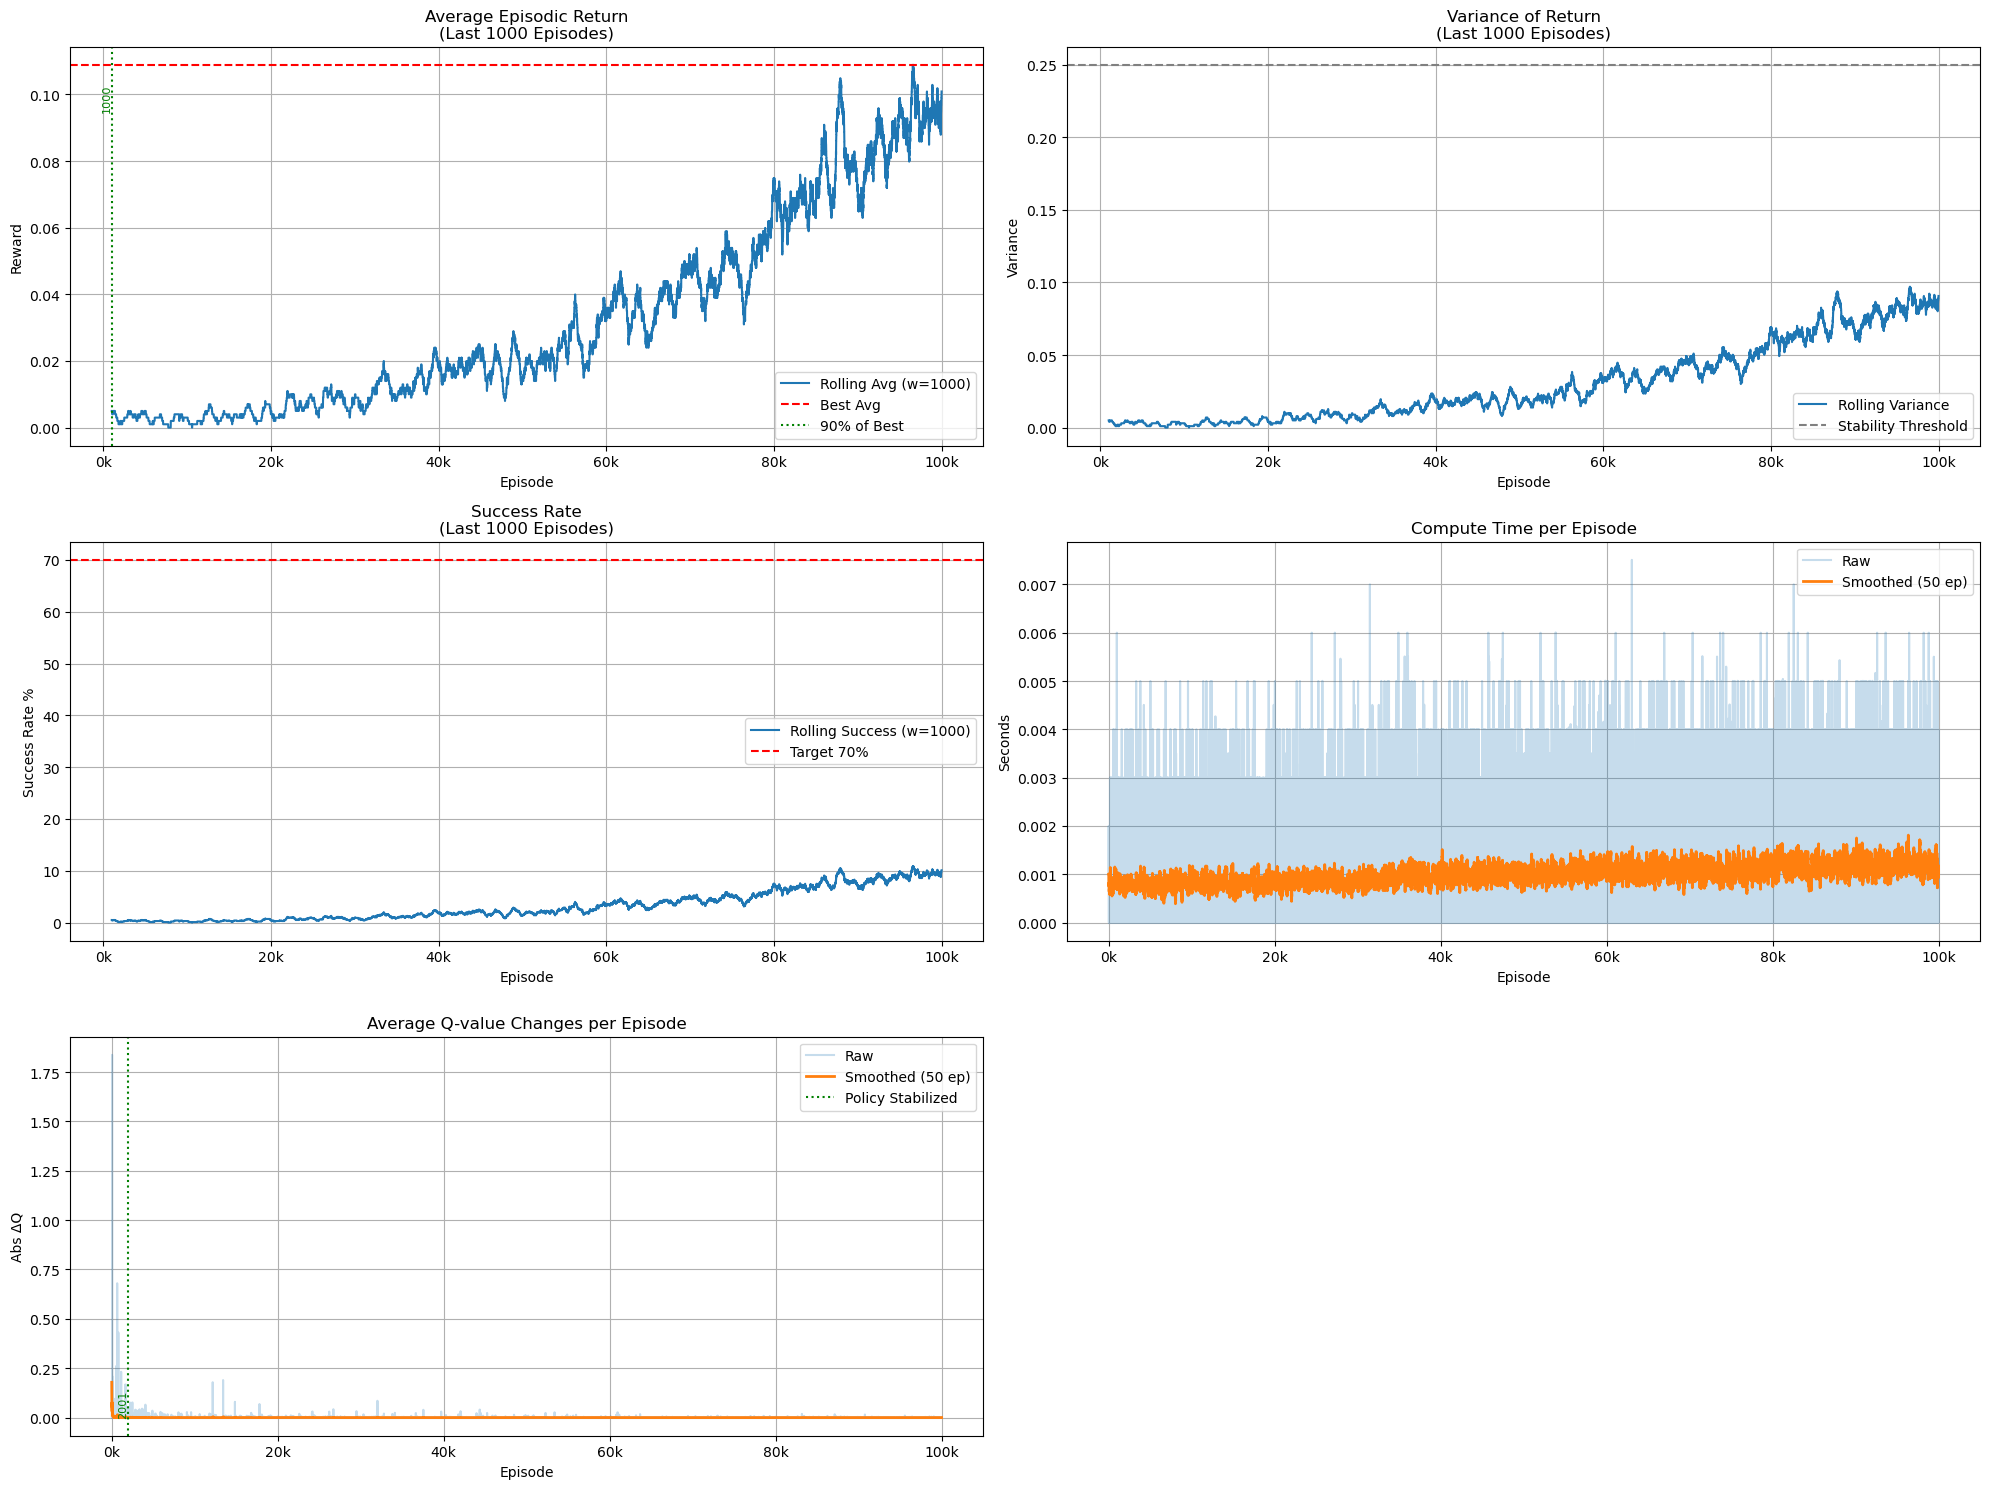


Training Monte Carlo First Visit


Monte Carlo First Visit Training: 100%|███████████████████████████████████████| 100000/100000 [04:40<00:00, 357.11it/s]



=== Monte Carlo First Visit Results ===
1. Final Success Rate: 80.82%
2. Average Reward: 0.808 ± 0.394
3. Best Rolling Average Return: 0.824
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0026 seconds
6. Policy converged after ~54294 episodes
Training Time: 280.03 seconds


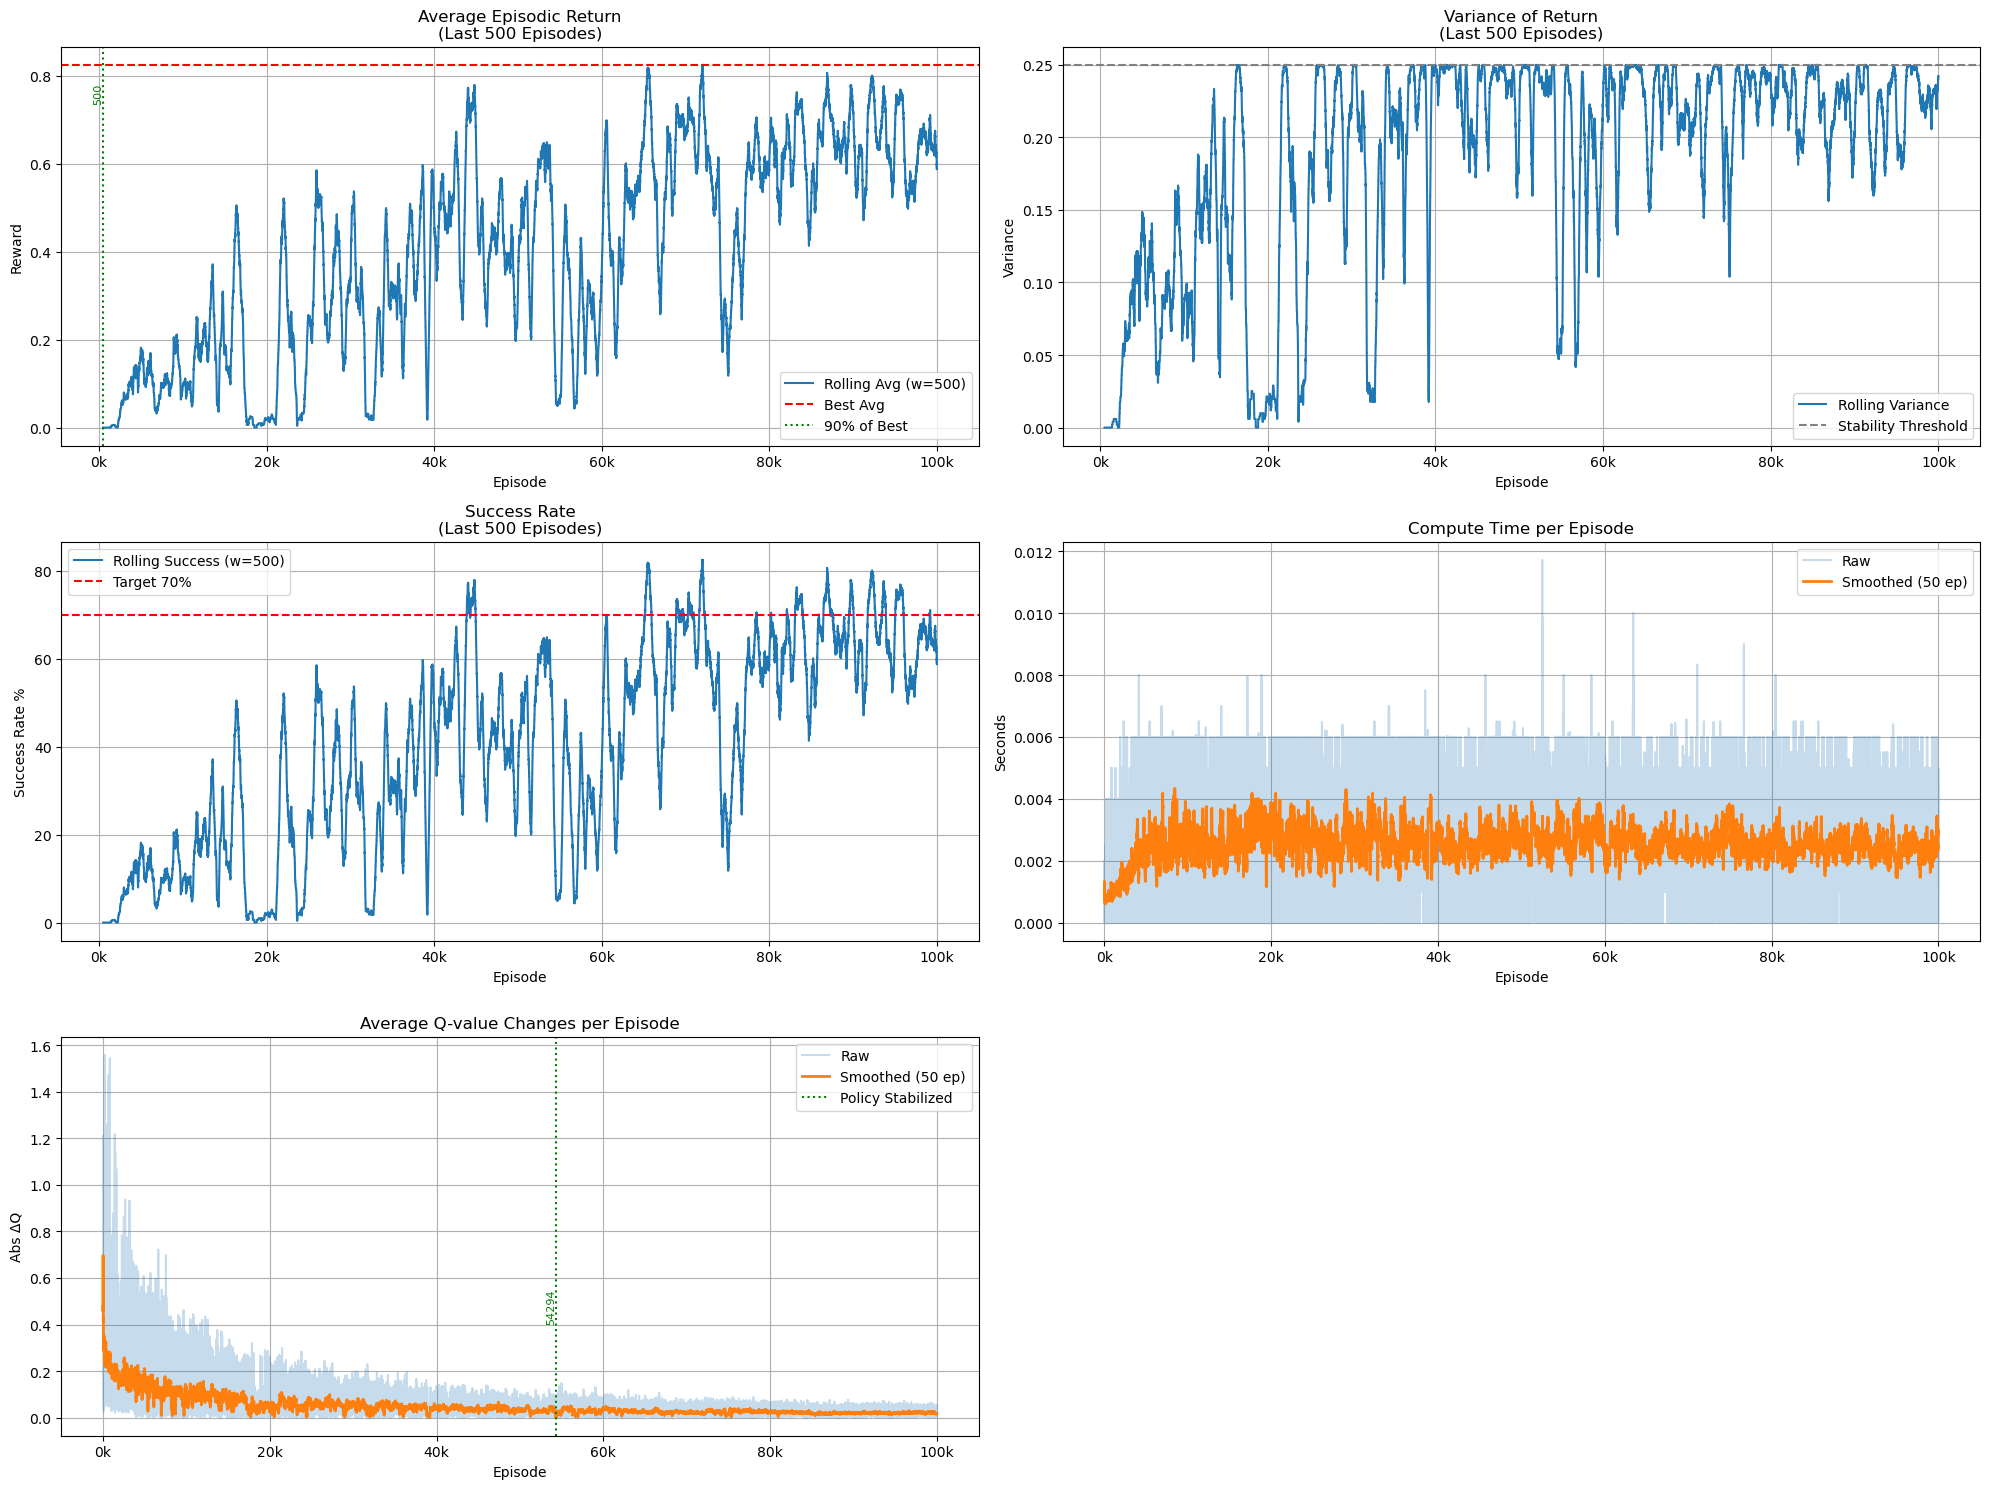


Training Double Dqn


Double Dqn Training: 100%|█████████████████████████████████████████████████████| 20000/20000 [1:04:38<00:00,  5.16it/s]



=== Double Dqn Results ===
1. Final Success Rate: 86.80%
2. Average Reward: 0.868 ± 0.338
3. Best Rolling Average Return: 0.125
4. Episodes to reach 90% of best: 8773
5. Average Compute Time per Episode: 0.1931 seconds
6. Policy did not fully converge during training
Training Time: 3878.74 seconds


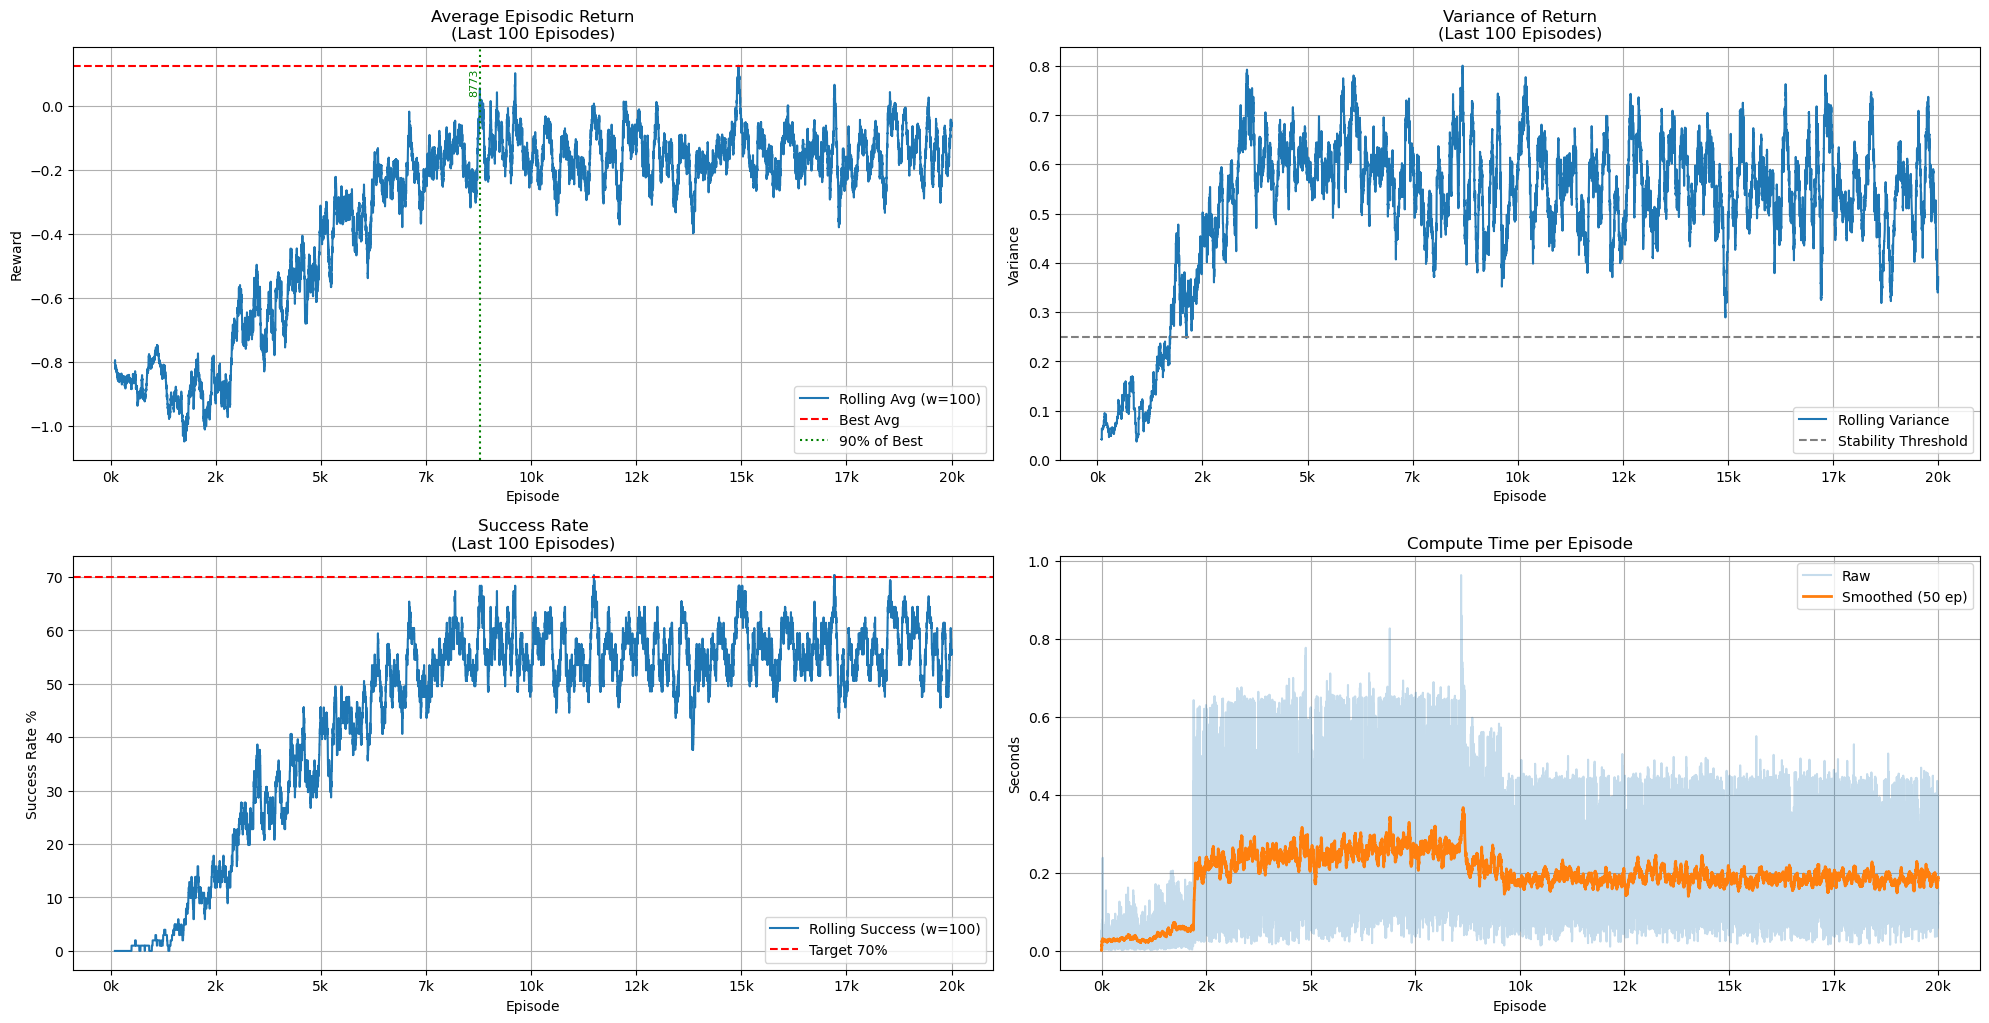

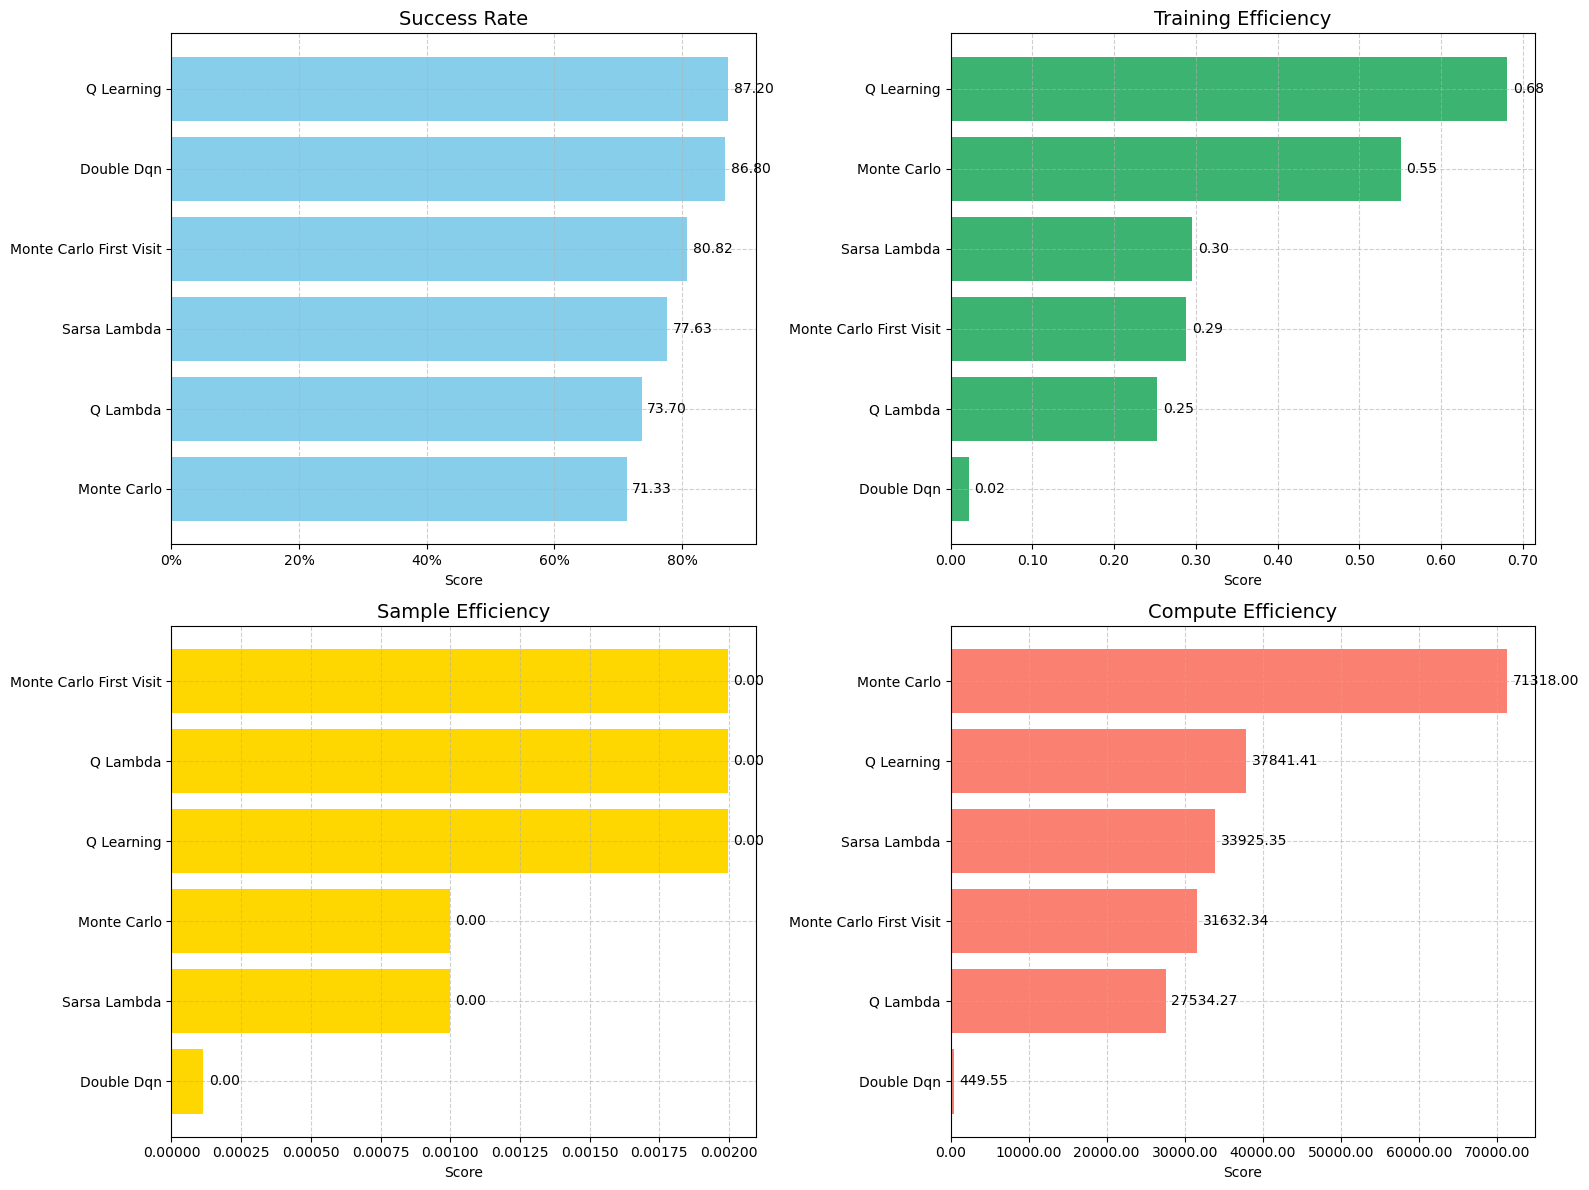

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import defaultdict, deque
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd

class FrozenLakeAgent:
    def __init__(self, algorithm='q_learning', **kwargs):
        self.env = gym.make('FrozenLake8x8-v1', is_slippery=True)
        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n
        self.algorithm = algorithm.lower()
        
        # Set parameters directly from kwargs
        self._set_parameters(**kwargs)
        
        # Initialize tracking metrics
        self.episode_rewards = []
        self.success_history = []
        self.compute_times = []
        self.rolling_avg = []
        self.rolling_success = []
        self.rolling_variance = []
        self.best_avg_return = -np.inf
        self.episodes_to_target = None
        self.target_percentage = 0.9  # 90% of best average return
        self.convergence_episode = None
        self.q_changes = []  # For tracking Q-value changes
        
        # Initialize algorithm-specific components
        self._init_algorithm()
    
    def _set_parameters(self, **kwargs):
        """Set parameters directly from kwargs"""
        for param, value in kwargs.items():
            setattr(self, param, value)
        
        # Ensure critical parameters have defaults
        self.episodes = int(getattr(self, 'episodes', 10000))
        self.test_episodes = int(getattr(self, 'test_episodes', 10000))
        self.window_size = int(getattr(self, 'window_size', 500))
        
        # Algorithm-specific defaults
        if self.algorithm == 'double_dqn':
            self.batch_size = int(getattr(self, 'batch_size', 32))
            self.update_every = int(getattr(self, 'update_every', 1))
            self.tau = float(getattr(self, 'tau', 0.01))
            self.learning_rate = float(getattr(self, 'learning_rate', 0.0005))
    
    def _init_algorithm(self):
        """Initialize algorithm-specific data structures"""
        if self.algorithm in ['monte_carlo', 'monte_carlo_first_visit']:
            self.Q = np.random.uniform(low=1.0, high=2.0, size=(self.n_states, self.n_actions))
            self.returns_sum = defaultdict(float)
            self.returns_count = defaultdict(float)
            if self.algorithm == 'monte_carlo_first_visit':
                self.learning_rate = getattr(self, 'learning_rate', 0.5)
        elif self.algorithm in ['sarsa_lambda', 'q_lambda']:
            self.Q = np.random.uniform(low=0.5, high=1.0, size=(self.n_states, self.n_actions))
            self.E = np.zeros((self.n_states, self.n_actions))
            self.lambda_ = getattr(self, 'lambda_', 0.5)
        elif self.algorithm == 'double_dqn':
            class QNetwork(nn.Module):
                def __init__(self, state_size, action_size):
                    super(QNetwork, self).__init__()
                    self.fc1 = nn.Linear(state_size, 64)
                    self.fc2 = nn.Linear(64, 64)
                    self.fc3 = nn.Linear(64, action_size)

                def forward(self, x):
                    x = torch.relu(self.fc1(x))
                    x = torch.relu(self.fc2(x))
                    return self.fc3(x)
            
            self.qnetwork_local = QNetwork(64, self.n_actions)
            self.qnetwork_target = QNetwork(64, self.n_actions)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
            self.criterion = nn.MSELoss()
            self.memory = deque(maxlen=100000)
        else:  # Q-learning
            self.Q = np.random.uniform(low=0.1, high=0.3, size=(self.n_states, self.n_actions))

    def choose_action(self, state, epsilon=None):
        """Epsilon-greedy action selection"""
        if epsilon is None:
            epsilon = getattr(self, 'epsilon', 0.1)
            
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])
    
    def shape_reward(self, reward, terminated):
        """Apply reward shaping"""
        goal_reward = getattr(self, 'goal_reward', 10)
        hole_penalty = getattr(self, 'hole_penalty', -5)
        step_penalty = getattr(self, 'step_penalty', -0.01)
        
        if terminated and reward == 1:
            return goal_reward
        elif terminated:
            return hole_penalty
        return step_penalty
    
    def train(self):
        """Train the agent using the selected algorithm"""
        start_time = time.time()
        
        # Initialize parameters with defaults if not provided
        self.epsilon = getattr(self, 'epsilon', 1.0)
        self.min_epsilon = getattr(self, 'min_epsilon', 0.01)
        self.epsilon_decay = getattr(self, 'epsilon_decay', 0.999)
        self.alpha = getattr(self, 'alpha', 0.5)
        self.gamma = getattr(self, 'gamma', 0.95)
        
        # Store initial Q-values for change tracking
        if self.algorithm != 'double_dqn':
            prev_Q = self.Q.copy()
        
        for episode in tqdm(range(self.episodes), desc=f"{self.algorithm.replace('_', ' ').title()} Training"):
            episode_start = time.time()
            
            if self.algorithm == 'monte_carlo':
                self._train_monte_carlo_episode()
            elif self.algorithm == 'monte_carlo_first_visit':
                self._train_monte_carlo_first_visit_episode()
            elif self.algorithm == 'sarsa_lambda':
                self._train_sarsa_lambda_episode()
            elif self.algorithm == 'q_lambda':
                self._train_q_lambda_episode()
            elif self.algorithm == 'double_dqn':
                self._train_double_dqn_episode()
            else:  # Q-learning
                self._train_q_learning_episode()
            
            # Update metrics
            self.compute_times.append(time.time() - episode_start)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.alpha = max(0.01, self.alpha * 0.99995) 
            
            # Track Q-value changes for convergence
            if self.algorithm != 'double_dqn':
                q_change = np.mean(np.abs(self.Q - prev_Q))
                self.q_changes.append(q_change)
                prev_Q = self.Q.copy()
            
            # Update rolling averages and variance
            if episode >= self.window_size:
                window_start = episode - self.window_size
                window_rewards = self.episode_rewards[window_start:episode+1]
                window_success = self.success_history[window_start:episode+1]
                
                self.rolling_avg.append(np.mean(window_rewards))
                self.rolling_success.append(np.mean(window_success) * 100)
                self.rolling_variance.append(np.var(window_rewards))
                
                # Track best average return
                current_avg = self.rolling_avg[-1]
                if current_avg > self.best_avg_return:
                    self.best_avg_return = current_avg
                
                # Check if we've reached target percentage of best return
                if (self.episodes_to_target is None and 
                    current_avg >= self.target_percentage * self.best_avg_return):
                    self.episodes_to_target = episode
                
                # Check for convergence (stable policy)
                if (self.convergence_episode is None and episode > self.window_size * 2 and
                    len(self.q_changes) > 10 and
                    np.mean(self.q_changes[-10:]) < 0.001):
                    self.convergence_episode = episode
        
        self.training_time = time.time() - start_time

    def _train_q_learning_episode(self):
        """TD(0) Q-Learning episode"""
        state, _ = self.env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            best_next = np.max(self.Q[next_state])
            
            # Q-learning update
            self.Q[state][action] = (1-self.alpha) * self.Q[state][action] + \
                                   self.alpha * (shaped_reward + self.gamma * best_next)

            self.alpha = max(0.01, self.alpha * 0.9999)
            
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)

    def _train_sarsa_lambda_episode(self):
        """SARSA(λ) episode"""
        self.E.fill(0)
        state, _ = self.env.reset()
        action = self.choose_action(state)
        done = False
        episode_reward = 0
        
        while not done:
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            next_action = self.choose_action(next_state)
            
            # Adaptive reward shaping
            shaped_reward = self.shape_reward(reward, terminated)
            if terminated and reward == 0:  # Fell in hole
                shaped_reward = -2  # Softer penalty than -5
                
            td_error = shaped_reward + self.gamma * self.Q[next_state][next_action] * (not done) - self.Q[state][action]
            
            # Controlled trace update
            self.E[state][action] = min(1.2, self.E[state][action] + (1 - 0.3*self.epsilon))
            
            # Stabilized learning update
            effective_alpha = self.alpha * (1 - 0.5*self.epsilon)  # Adaptive learning rate
            self.Q += effective_alpha * td_error * self.E
            
            # Stronger trace decay
            self.E *= self.gamma * self.lambda_ * (0.97 - 0.15*self.epsilon)
            
            episode_reward += reward
            state, action = next_state, next_action
        
        self._update_metrics(episode_reward)

    def _train_q_lambda_episode(self):
        """Optimized Q(λ) episode"""
        self.E.fill(0)
        state, _ = self.env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Dynamic reward shaping
            shaped_reward = 30 if (terminated and reward == 1) else \
                           -1.5 if terminated else \
                           -0.005 * (1 + self.epsilon)  # Exploration-dependent step penalty
            
            best_next_action = np.argmax(self.Q[next_state])
            td_error = shaped_reward + self.gamma * self.Q[next_state][best_next_action] * (not done) - self.Q[state][action]
            
            # Smart trace updates
            self.E[state][action] = min(1.5, self.E[state][action] + (1 - 0.2*self.epsilon))
            self.Q += self.alpha * td_error * self.E
            self.E *= self.gamma * self.lambda_ * (0.95 - 0.1*self.epsilon)
            if np.max(self.E) > 5:  # Threshold can be adjusted
                self.E.fill(0)
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)
    
    def _train_monte_carlo_episode(self):
        """Monte Carlo (Every-Visit) episode"""
        state, _ = self.env.reset()
        done = False
        episode_history = []
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            episode_history.append((state, action, shaped_reward))
            episode_reward += reward
            state = next_state
        
        # Calculate returns and update Q-values (Every-Visit)
        G = 0
        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = G * self.gamma + reward
            
            self.returns_sum[(state, action)] += G
            self.returns_count[(state, action)] += 1
            self.Q[state][action] = self.returns_sum[(state, action)] / self.returns_count[(state, action)]
        
        self._update_metrics(episode_reward)
    
    def _train_monte_carlo_first_visit_episode(self):
        """Monte Carlo (First-Visit) episode"""
        state, _ = self.env.reset()
        done = False
        episode_history = []
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            episode_history.append((state, action, shaped_reward))
            episode_reward += reward
            state = next_state
        
        # Calculate returns and update Q-values (First-Visit)
        G = 0
        first_visits = set()
        
        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = G * self.gamma + reward
            
            if (state, action) not in first_visits:
                first_visits.add((state, action))
                alpha = self.learning_rate / (1 + (len(self.episode_rewards) / 10000))
                self.Q[state][action] += alpha * (G - self.Q[state][action]) * (1 + 0.5*self.epsilon)
        
        self._update_metrics(episode_reward)
    
    def _train_double_dqn_episode(self):
        """Double DQN episode"""
        state, _ = self.env.reset()
        state = self._one_hot_encode(state)
        done = False
        episode_reward = 0
        
        while not done:
            action = self._dqn_act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Custom rewards for DQN
            if terminated:
                if self.env.unwrapped.desc.flatten()[next_state] == b'G':
                    reward = self.goal_reward  # Goal
                else:
                    reward = self.hole_penalty  # Hole
            else:
                reward = self.step_penalty  # Per timestep penalty
            
            next_state = self._one_hot_encode(next_state)
            self.memory.append((state, action, reward, next_state, done))
            
            if len(self.memory) > self.batch_size and len(self.memory) % self.update_every == 0:
                self._dqn_learn()
            
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)
    
    def _dqn_act(self, state, eps=None):
        """DQN action selection"""
        if eps is None:
            eps = self.epsilon
            
        if random.random() > eps:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_actions))
    
    def _dqn_learn(self):
        """Update DQN parameters"""
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.FloatTensor(np.vstack(states))
        actions = torch.LongTensor(np.vstack(actions))
        rewards = torch.FloatTensor(np.vstack(rewards))
        next_states = torch.FloatTensor(np.vstack(next_states))
        dones = torch.FloatTensor(np.vstack(dones))

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = self.criterion(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update target network
        self._soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
    
    def _soft_update(self, local_model, target_model, tau):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def _one_hot_encode(self, state, size=64):
        """One-hot encode state for DQN"""
        vec = np.zeros(size)
        vec[state] = 1
        return vec
    
    def _update_metrics(self, episode_reward):
        """Update tracking metrics"""
        self.episode_rewards.append(episode_reward)
        self.success_history.append(1 if episode_reward > 0 else 0)
    
    def test(self):
        """Evaluate the trained policy"""
        success_count = 0
        test_rewards = []
        
        for _ in range(self.test_episodes):
            if self.algorithm == 'double_dqn':
                state, _ = self.env.reset()
                state = self._one_hot_encode(state)
            else:
                state, _ = self.env.reset()
                
            done = False
            episode_reward = 0
            
            while not done:
                if self.algorithm == 'double_dqn':
                    action = self._dqn_act(state, eps=0.0)
                else:
                    action = np.argmax(self.Q[state])
                    
                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                if self.algorithm == 'double_dqn':
                    state = self._one_hot_encode(state)
                
                episode_reward += reward
            
            test_rewards.append(episode_reward)
            if episode_reward > 0:
                success_count += 1
        
        self.success_rate = (success_count / self.test_episodes) * 100
        self.avg_reward = np.mean(test_rewards)
        self.test_variance = np.var(test_rewards)

    def plot_results(self):
        import pandas as pd
        import matplotlib.ticker as mtick
    
        episodes_range = np.arange(self.window_size, self.episodes)
    
        def fmt_k(ax):
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f'{int(x/1000)}k'))
    
        plt.figure(figsize=(20, 15))
    
        # --- Avg Return ---
        ax = plt.subplot(3, 2, 1)
        plt.plot(episodes_range, self.rolling_avg, label=f'Rolling Avg (w={self.window_size})')
        plt.axhline(y=self.best_avg_return, color='r', ls='--', label='Best Avg')
        if self.episodes_to_target:
            plt.axvline(x=self.episodes_to_target, color='g', ls=':', 
                        label=f'{self.target_percentage*100:.0f}% of Best')
            plt.text(self.episodes_to_target, self.best_avg_return*0.95,
                     f'{self.episodes_to_target}', color='g', rotation=90, va='top', ha='right', fontsize=8)
        plt.title(f'Average Episodic Return\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Reward'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Variance ---
        ax = plt.subplot(3, 2, 2)
        plt.plot(episodes_range, self.rolling_variance, label='Rolling Variance')
        plt.axhline(y=0.25, color='gray', ls='--', label='Stability Threshold')
        plt.title(f'Variance of Return\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Variance'); plt.grid(True); plt.legend()
        fmt_k(ax)
    
        # --- Success Rate ---
        ax = plt.subplot(3, 2, 3)
        plt.plot(episodes_range, self.rolling_success, label=f'Rolling Success (w={self.window_size})')
        plt.axhline(y=70, color='r', ls='--', label='Target 70%')
        plt.title(f'Success Rate\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Success Rate %'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Compute Time ---
        ax = plt.subplot(3, 2, 4)
        raw_times = np.array(self.compute_times)
        compute_smoothed = pd.Series(raw_times).rolling(50, min_periods=1).mean()
        plt.plot(raw_times, alpha=0.25, label='Raw')
        plt.plot(compute_smoothed, linewidth=2, label='Smoothed (50 ep)')
        plt.title('Compute Time per Episode')
        plt.xlabel('Episode'); plt.ylabel('Seconds'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Q-value Change ---
        if self.algorithm != 'double_dqn':
            ax = plt.subplot(3, 2, 5)
            raw_q = np.array(self.q_changes)
            q_smoothed = pd.Series(raw_q).rolling(50, min_periods=1).mean()
            plt.plot(raw_q, alpha=0.25, label='Raw')
            plt.plot(q_smoothed, linewidth=2, label='Smoothed (50 ep)')
            if self.convergence_episode:
                plt.axvline(x=self.convergence_episode, color='g', ls=':', label='Policy Stabilized')
                plt.text(self.convergence_episode, np.nanmax(q_smoothed)*0.8,
                         f'{self.convergence_episode}', color='g', rotation=90, va='top', ha='right', fontsize=8)
            plt.title('Average Q-value Changes per Episode')
            plt.xlabel('Episode'); plt.ylabel('Abs ΔQ'); plt.grid(True); plt.legend()
            fmt_k(ax)
    
        plt.tight_layout()
        plt.show()
    
    def print_results(self):
        """Print final results"""
        print(f"\n=== {self.algorithm.replace('_', ' ').title()} Results ===")
        print(f"1. Final Success Rate: {self.success_rate:.2f}%")
        print(f"2. Average Reward: {self.avg_reward:.3f} ± {np.sqrt(self.test_variance):.3f}")
        print(f"3. Best Rolling Average Return: {self.best_avg_return:.3f}")
        
        if self.episodes_to_target:
            print(f"4. Episodes to reach {self.target_percentage*100:.0f}% of best: {self.episodes_to_target}")
        else:
            print(f"4. Never reached {self.target_percentage*100:.0f}% of best average return")
        
        print(f"5. Average Compute Time per Episode: {np.mean(self.compute_times):.4f} seconds")
        
        if self.convergence_episode:
            print(f"6. Policy converged after ~{self.convergence_episode} episodes")
        else:
            print("6. Policy did not fully converge during training")
        
        print(f"Training Time: {self.training_time:.2f} seconds")
    
    @staticmethod
    def compare_algorithms(results):
        """Plot comparison of agent performance metrics (no DataFrame returned)"""
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        import numpy as np
    
        # Collect metrics
        metrics = {
            'Success Rate': {},
            'Training Efficiency': {},
            'Sample Efficiency': {},
            'Compute Efficiency': {}
        }
    
        for algo, agent in results.items():
            success_rate = agent.success_rate
            training_time = agent.training_time
            compute_time = np.mean(agent.compute_times)
            episodes_to_target = agent.episodes_to_target if agent.episodes_to_target else agent.episodes
    
            metrics['Success Rate'][algo] = success_rate
            metrics['Training Efficiency'][algo] = success_rate / training_time
            metrics['Sample Efficiency'][algo] = 1 / (episodes_to_target + 1)
            metrics['Compute Efficiency'][algo] = success_rate / compute_time

        # Setup plot
        plt.figure(figsize=(16, 12))
        titles = list(metrics.keys())
        colors = ['skyblue', 'mediumseagreen', 'gold', 'salmon']
    
        for i, (title, values) in enumerate(metrics.items()):
            plt.subplot(2, 2, i + 1)
            sorted_vals = dict(sorted(values.items(), key=lambda item: item[1]))
            agents = list(sorted_vals.keys())
            scores = list(sorted_vals.values())
    
            bars = plt.barh(agents, scores, color=colors[i])
            plt.title(title, fontsize=14)
            plt.xlabel('Score')
            plt.grid(True, linestyle='--', alpha=0.6)

            # Apply formatting
            ax = plt.gca()
            if "Success" in title:
                ax.xaxis.set_major_formatter(mtick.PercentFormatter())
            elif "Sample" in title:
                ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.5f}"))
            else:
                ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}"))
    
            # Annotate values
            for bar, score in zip(bars, scores):
                ax.text(bar.get_width() + max(scores) * 0.01, bar.get_y() + bar.get_height() / 2,
                        f"{score:.2f}", va='center', fontsize=10)
    
        plt.tight_layout()
        plt.show()


# Example usage with custom parameters
if __name__ == "__main__":
    algorithms = [
        'q_learning', 
        'sarsa_lambda', 
        'q_lambda', 
        'monte_carlo',
        'monte_carlo_first_visit',
        'double_dqn'
    ]
    
    # Custom parameters for each algorithm
    custom_params = {
        'q_learning': {
            'episodes': 50000,
            'alpha': 0.3,           # Reduced from 0.5 for stability
            'gamma': 0.99,
            'epsilon': 1.0,
            'min_epsilon': 0.1,     # Increased from 0.05
            'epsilon_decay': 0.9999, # Slower decay
            'goal_reward': 20,
            'hole_penalty': -3,     # Less harsh than -5
            'step_penalty': -0.01,
            'window_size': 500,
            'test_episodes': 1000
        },

        'sarsa_lambda': {
            'episodes': 100000,
            'alpha': 0.4,           # Reduced from 0.5
            'gamma': 0.98,
            'lambda_': 0.5,         # Increased from 0.3
            'epsilon': 1.0,
            'min_epsilon': 0.05,    # Increased from 0.02
            'epsilon_decay': 0.9999, # Slower decay reduced from 0.999
            'goal_reward': 30,
            # 'hole_penalty': -2,     # Reduced from -5
            'hole_penalty': -1.5,  # Further soften from -2
            # 'step_penalty': -0.01,
            'step_penalty': -0.005, # Half the penalty
            'window_size': 1000,  # Latest Better for long training runs
            'test_episodes':10000
        },

       
        'q_lambda': {
            'episodes': 100000,
            'alpha': 0.25,          # Reduced from 0.3 for stability
            'gamma': 0.95,
            'lambda_': 0.8,         # Increased from 0.7 for longer traces
            'epsilon': 1.0,
            'min_epsilon': 0.08,    # More persistent exploration
            'epsilon_decay': 0.9999, # Slower exploration decay
            'goal_reward': 30,
            'hole_penalty': -1.5,   # Softer than -2
            'step_penalty': -0.01,
            'window_size': 500,
            'test_episodes':10000
        },

        'monte_carlo': {
            'episodes': 100000,  # Increased from 50k
            'gamma': 0.999,      # Higher discount
            'epsilon': 1.0,
            'min_epsilon': 0.1,  # Increased from 0.01
            'epsilon_decay': 0.99999,  # Slower decay
            'goal_reward': 30,
            'hole_penalty': -1,  # Softer from -5
            'step_penalty': -0.001,  # Reduced from -0.005
            'window_size': 1000, # from 500
            'test_episodes':10000
        },

        'monte_carlo_first_visit': {
            'episodes': 100000,
            'gamma': 0.95,
            'min_epsilon': 0.01,
            'epsilon_decay': 0.999,
            'learning_rate': 0.8,
            'goal_reward': 20,
            'hole_penalty': -10,
            'step_penalty': -0.02,
            'window_size': 500,
            'test_episodes':10000
        },
        
        'double_dqn': {
            'episodes': 20000,
            'gamma': 0.99,
            'epsilon': 1.0,
            'min_epsilon': 0.01,
            'epsilon_decay': 0.9995,
            'learning_rate': 0.0005,
            'batch_size': 64,
            'update_every': 4,
            'tau': 0.01,
            'goal_reward': 1.0,
            'hole_penalty': -0.5,
            'step_penalty': -0.01,
            'window_size': 100,
            'test_episodes':1000
        }
    }
    
    results = {}
    
    for algo in algorithms:
        print(f"\n{'='*40}\nTraining {algo.replace('_', ' ').title()}\n{'='*40}")
        
        params = custom_params.get(algo, {})
        agent = FrozenLakeAgent(algorithm=algo, **params)
        agent.train()
        agent.test()
        agent.print_results()
        agent.plot_results()
        
        results[algo.replace('_', ' ').title()] = agent
    
    FrozenLakeAgent.compare_algorithms(results)

# FrozenLake RL Agents: Optimization Analysis

## Key Improvements

#### Q-Learning:
- Reduced learning rate (α) from 0.5 to 0.3 for stability  
- Increased minimum epsilon from 0.05 to 0.1 for persistent exploration  
- Slowed epsilon decay (0.9999)  
- Softened hole penalty from -5 to -3  
- Increased goal reward from 10 to 20  

#### SARSA(λ):
- Increased λ from 0.3 to 0.5 for longer eligibility traces  
- Reduced hole penalty from -5 to -1.5  
- Halved step penalty from -0.01 to -0.005  
- Added exploration-dependent step penalty  

#### Q(λ):
- Reduced α from 0.3 to 0.25  
- Increased λ from 0.7 to 0.8  
- Added dynamic reward shaping    

#### Monte Carlo:
- Increased discount factor γ to 0.999  
- Softened hole penalty from -5 to -1  
- Reduced step penalty from -0.005 to -0.001  
- Slowed epsilon decay (0.99999)  

#### Monte Carlo First Visit:
- Added adaptive learning rate that decreases with experience   

#### Double DQN:
- Increased batch size from 32 to 64  
- Changed update frequency from every step to every 4 steps  
- Reduced τ from 0.1 to 0.01 for slower target network updates  

## Performance Results

| Algorithm            | Success Rate | Avg Reward (±std) | Best Avg Return | Variance (σ²) | Training Time | Sample Efficiency |
|----------------------|--------------|-------------------|-----------------|---------------|---------------|-------------------|
| Q-Learning           | 87.20%       | 0.872 ± 0.334     | 0.607           | 0.112         | 128.04s       | 500 episodes      |
| SARSA(λ)            | 77.63%       | 0.776 ± 0.417     | 0.716           | 0.174         | 262.57s       | 1000 episodes     |
| Q(λ)                | 73.70%       | 0.737 ± 0.440     | 0.573           | 0.194         | 291.48s       | 500 episodes      |
| Monte Carlo          | 71.33%       | 0.713 ± 0.452     | 0.109           | 0.204         | 129.48s       | 1000 episodes     |
| MC First Visit       | 80.82%       | 0.808 ± 0.394     | 0.824           | 0.155         | 280.03s       | 500 episodes      |
| Double DQN           | 86.80%       | 0.868 ± 0.338     | 0.125           | 0.114         | 3878.74s      | 8773 episodes     |

